# Árboles de Clasificación

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

In [3]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='OP_UNIQUE_CARRIER',
                        outputCol='IndexUniqueCarrier') #el índice empieza en el 0!
bd6=indexer.fit(bd5).transform(bd5)

bd6.groupBy('OP_UNIQUE_CARRIER','IndexUniqueCarrier').count().sort('IndexUniqueCarrier').show()


+-----------------+------------------+-----+
|OP_UNIQUE_CARRIER|IndexUniqueCarrier|count|
+-----------------+------------------+-----+
|               AA|               0.0| 8853|
|               UA|               1.0| 6112|
|               WN|               2.0| 5395|
|               DL|               3.0| 4239|
|               VX|               4.0| 1703|
|               NK|               5.0| 1581|
|               F9|               6.0| 1295|
|               OO|               7.0| 1166|
|               B6|               8.0|  121|
|               EV|               9.0|    1|
+-----------------+------------------+-----+



## Ajuste del modelo

In [4]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import col

a1  = VectorAssembler(
    inputCols=['DEP_DELAY','DISTANCE','DAY_OF_WEEK',
               'CRS_DEP_TIME','IndexUniqueCarrier'],
    outputCol='features')

bd7 = a1.transform(bd6).select(col("Retraso").cast('double').alias("label"),'features')

stringIndexer = StringIndexer(inputCol = 'label', outputCol = 'label2')
sI = stringIndexer.fit(bd7)
bd7 = sI.transform(bd7)



### Partición Test - Train

In [5]:
(bd_train, bd_test) = bd7.randomSplit([0.7, 0.3],seed=123)
print(bd_train.count())
print(bd_test.count())

21278
9188


In [6]:
from pyspark.ml.classification import DecisionTreeClassifier as DTC

rt = DTC(maxDepth=5, labelCol = 'label2')

model = rt.fit(bd_train)
pred = model.transform(bd_train)

In [7]:
pred.show()

+-----+--------------------+------+--------------+--------------------+----------+
|label|            features|label2| rawPrediction|         probability|prediction|
+-----+--------------------+------+--------------+--------------------+----------+
|  0.0|[-20.0,602.0,3.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|
|  0.0|[-16.0,641.0,1.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|
|  0.0|[-16.0,641.0,6.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|
|  0.0|[-16.0,868.0,6.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|
|  0.0|[-16.0,888.0,3.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|
|  0.0|[-15.0,731.0,1.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|
|  0.0|[-15.0,888.0,4.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|
|  0.0|[-15.0,888.0,5.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|
|  0.0|[-15.0,967.0,3.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|
|  0

In [8]:
pred.groupBy('probability').count().show(50)


+--------------------+-----+
|         probability|count|
+--------------------+-----+
|[0.12149532710280...|  107|
|[0.69696969696969...|   33|
|[0.07692307692307...|   39|
|[0.94122079879427...| 1327|
|[0.89046270066100...| 1059|
|   [0.78125,0.21875]|  128|
|[0.51086956521739...|   92|
|[0.31034482758620...|   87|
|[0.93431528662420...| 2512|
|[0.07438016528925...|  121|
|           [0.0,1.0]| 2635|
|[0.34693877551020...|   49|
|[0.14655172413793...|  116|
|[0.96054911368785...| 7503|
|[0.02158273381294...|  139|
|[0.87884378843788...| 1626|
|[0.76311605723370...|  629|
|[0.79834254143646...|  362|
|[0.68522072936660...|  521|
|[0.33720930232558...|   86|
|[0.49253731343283...|   67|
|[0.45604395604395...|  364|
|[0.20247933884297...|  242|
|[0.63035019455252...|  514|
|[0.71428571428571...|    7|
|[0.19298245614035...|  171|
|[0.00777202072538...|  386|
|[0.89898989898989...|   99|
|[0.35080645161290...|  248|
|[0.88888888888888...|    9|
+--------------------+-----+



In [9]:
pred.groupBy('label','prediction').count().show()
#threshold = 0.5

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 4368|
|  0.0|       0.0|14897|
|  0.0|       1.0|  489|
|  1.0|       0.0| 1524|
+-----+----------+-----+



### Curva ROC

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

secondelement=udf(lambda v:float(v[1]),FloatType())
pred2=pred.withColumn('probs',secondelement('probability'))

pred2.show(10)

+-----+--------------------+------+--------------+--------------------+----------+-----------+
|label|            features|label2| rawPrediction|         probability|prediction|      probs|
+-----+--------------------+------+--------------+--------------------+----------+-----------+
|  0.0|[-20.0,602.0,3.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|0.039450888|
|  0.0|[-16.0,641.0,1.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|0.039450888|
|  0.0|[-16.0,641.0,6.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|0.039450888|
|  0.0|[-16.0,868.0,6.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|0.039450888|
|  0.0|[-16.0,888.0,3.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|0.039450888|
|  0.0|[-15.0,731.0,1.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|0.039450888|
|  0.0|[-15.0,888.0,4.0,...|   0.0|[7207.0,296.0]|[0.96054911368785...|       0.0|0.039450888|
|  0.0|[-15.0,888.0,5.0,...|   0.0|[7207.0,296.0]|

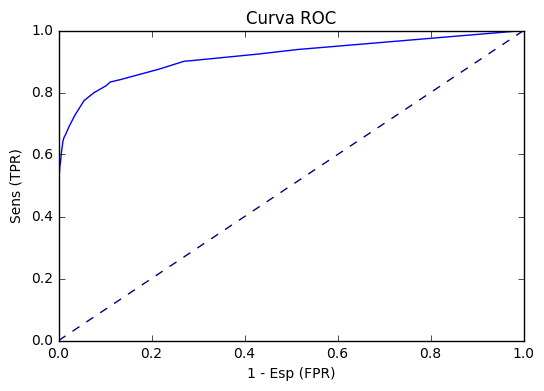

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import seaborn as sns

pd5 = pred2.sample(False,0.1).select('label','probs').toPandas()

fpr, tpr, _ = roc_curve( pd5['label'], pd5['probs'])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('1 - Esp (FPR)')
plt.ylabel('Sens (TPR)')
plt.title('Curva ROC')
plt.show()

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(pred))


AUC= 0.9222584966504406


In [13]:
# DecisionTreeClassifier(featuresCol="features",
#    labelCol="label",
#    predictionCol="prediction",
#    probabilityCol="probability",
#    rawPredictionCol="rawPrediction",
#    maxDepth=5,
#    maxBins=32,
#    minInstancesPerNode=1,
#    minInfoGain=0.0,
#    maxMemoryInMB=256,
#    impurity="gini"  / impurity="entropy" )

In [14]:
rt = DTC(maxDepth=20, labelCol = 'label2')
model = rt.fit(bd_train)
pred = model.transform(bd_train)

print('AUC=',BCE(metricName="areaUnderROC", rawPredictionCol = 'probability').evaluate(pred))

AUC= 0.999437809422678


### Validación externa

In [15]:
predtest = model.transform(bd_test)

print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(predtest))

AUC= 0.8206132723811288
